In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("../data/avis/general_df_clean_sent_15k.csv")

In [26]:
df.head()

,Unnamed: 0,user,etoiles,n_avis,localisation,date_avis,titre_avis,text_avis,date_experience,page,label,score,sentiment_norm,longueur_text
0,0,Sylvain Andujar,3,3.0,FR,2022-07-26 10:10:19,Pour l'instant toujours en attente,"Pour l'instant toujours en attente, tout les j...",2022-07-26,YounitedCredit,-1,0.939534,-0.939534,138.0
1,1,ANNICK JALLET,3,1.0,FR,2022-04-11 14:14:30,intérêts trop élevés,na,2022-04-11,Cofidis,-1,0.838470,-0.838470,2.0
2,2,Client,2,3.0,FR,2023-06-07 16:57:39,"C'était les meilleurs, mais c'était avant",Deux dernières fois où j'ai dû faire appel à F...,2023-06-04,Fortuneo,-1,0.889320,-0.889320,289.0
3,3,Radio Anime,1,1.0,BE,2023-09-08 13:30:04,Vous n'aidez pas les gens,"Vous n'aidez pas les gens, vous faites l'inver...",2023-09-08,Cofidis,-1,0.899752,-0.899752,189.0
4,4,Serge Péon,1,2.0,FR,2023-02-10 20:32:37,De voyage à l'étranger mon conseillé de…,De voyage à l'étranger mon conseillé de la Ban...,2023-02-09,MaFrenchBank,-1,0.984039,-0.984039,478.0


In [40]:
# Vectorization of the text with TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # Limit to 1000 features for simplicity
X = tfidf_vectorizer.fit_transform(df['text_avis'])
print(X)

  (0, 425)	0.3466822305877351
  (0, 301)	0.25329622563864096
  (0, 265)	0.1610824623218354
  (0, 643)	0.11279733486003869
  (0, 366)	0.11029566274703842
  (0, 744)	0.13939109032492628
  (0, 595)	0.271039602497694
  (0, 267)	0.08236597375626353
  (0, 198)	0.3369461852187532
  (0, 741)	0.2663835528732386
  (0, 538)	0.27760932506167996
  (0, 461)	0.1504768769514441
  (0, 498)	0.19476163949672542
  (0, 509)	0.24140822228906503
  (0, 910)	0.1760105949600675
  (0, 103)	0.24626394999815188
  (0, 345)	0.11836725893348521
  (0, 908)	0.19439658000140936
  (0, 481)	0.3583879690455469
  (0, 682)	0.11339490952666116
  (1, 580)	1.0
  (2, 158)	0.20763969121912398
  (2, 533)	0.20181751248209762
  (2, 137)	0.11568049028070536
  (2, 504)	0.07888710867288265
  :	:
  (15049, 750)	0.09042017364406926
  (15049, 341)	0.12282184592476818
  (15049, 428)	0.11340513440842273
  (15049, 657)	0.17121756085219267
  (15049, 173)	0.1761984176516801
  (15049, 736)	0.06572440154721927
  (15049, 493)	0.1210382791653366
 

In [41]:
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the feature names
print(feature_names)

['000' '01' '04' '08' '09' '10' '100' '1000' '11' '12' '13' '14' '15' '17'
 '18' '1er' '20' '2020' '2021' '2022' '2023' '24' '24h' '25' '28' '30'
 '48' '48h' '4x' '50' '5000' '60' '60000' 'aboutir' 'absolument'
 'acceptation' 'accepter' 'accepté' 'accompagnement' 'accord' 'accueil'
 'accueillante' 'accès' 'accéder' 'achat' 'achats' 'acheter' 'acte'
 'activités' 'actuelle' 'actuellement' 'actuels' 'adapté' 'adresse' 'afin'
 'agence' 'agit' 'agréable' 'ai' 'aide' 'aider' 'ailleurs' 'aimerais'
 'ainsi' 'air' 'aller' 'allez' 'alors' 'an' 'analyse' 'android' 'annonce'
 'annoncé' 'annoncés' 'annulation' 'annulé' 'année' 'années' 'anodin'
 'ans' 'anytime' 'appel' 'appeler' 'appelle' 'appels' 'appelé' 'appli'
 'application' 'appréciable' 'apres' 'après' 'argent' 'arnaque' 'arrive'
 'arrivé' 'as' 'assez' 'assurance' 'assurances' 'attend' 'attendant'
 'attendre' 'attends' 'attente' 'attention' 'au' 'auchan' 'aucun' 'aucune'
 'aujourd' 'auprès' 'aurai' 'aurais' 'aurait' 'aussi' 'autant' 'auto'
 '

In [42]:
# rajouter des variables clé

variables_extra =df[["sentiment_norm", "longueur_text"]]

# mettre les variables en plus en format dense
from scipy.sparse import csr_matrix, hstack

X = hstack([X, csr_matrix(variables_extra)])


Accuracy: 0.5794019933554817
Classification Report: 
              precision    recall  f1-score   support

           1       0.54      0.66      0.60       614
           2       0.43      0.31      0.36       576
           3       0.44      0.32      0.37       627
           4       0.53      0.81      0.64       587
           5       0.99      0.80      0.88       606

    accuracy                           0.58      3010
   macro avg       0.59      0.58      0.57      3010
weighted avg       0.59      0.58      0.57      3010



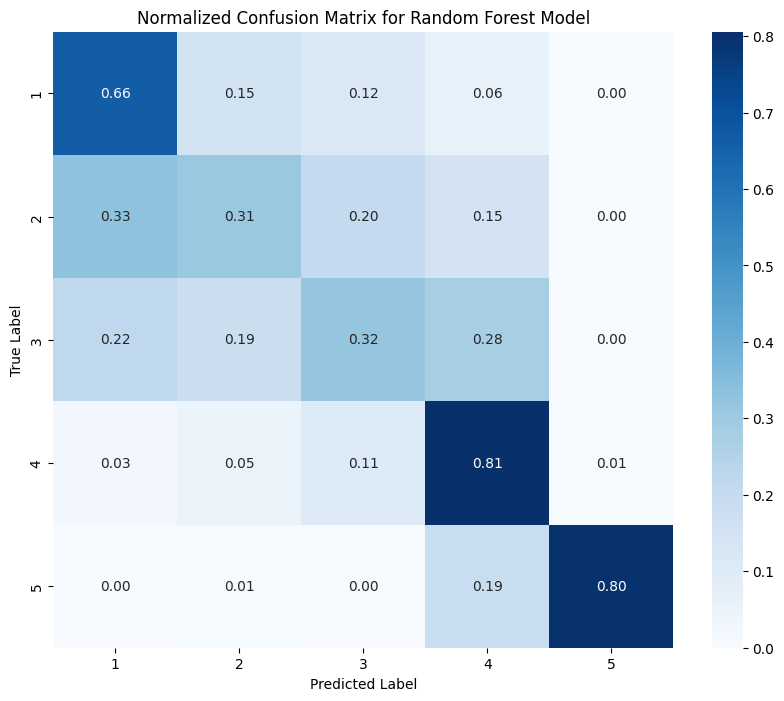

In [43]:
# Prepare the data
y = df['etoiles']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=10, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the performance of the model
print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{class_report}')

# Generate and normalize the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Normalized Confusion Matrix for Random Forest Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [55]:
# Essai grid
from sklearn.model_selection import GridSearchCV 
  
# definir des hyper paramètres à tester
param_grid = {'n_estimators': [10, 50, 100, 200, 300],  
              'max_depth': [None, 10, 20, 30], 
              'min_samples_split': [2, 5, 10, 20, 30 ],
              'min_samples_leaf':[1, 2, 4]
              } 

# tester les différents paramètres
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv = 5, n_jobs=-1, verbose = 3)

grid.fit(X_train, y_train)


Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV 5/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.630 total time=   1.9s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.613 total time=   1.9s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.616 total time=   1.9s
[CV 2/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.619 total time=   2.0s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=0.613 total time=   2.0s
[CV 4/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.642 total time=   9.5s
[CV 3/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.653 total time=   9.5s
[CV 1/5] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50;, score=0.650 tot

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10, 20, 30],
                         'n_estimators': [10, 50, 100, 200, 300]},
             verbose=3)

In [51]:
print("Bet parameters:", grid.best_params_)

Bet parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 200}


In [52]:
print("\n",grid.score(X_train, y_train))


 0.9533222591362126


In [53]:
y_pred = grid.predict(X_test)
pd.crosstab(y_test, y_pred, rownames=['Classes réelles'], colnames=['Classes prédites'])

Classes prédites,1,2,3,4,5
Classes réelles,,,,,
1,467,89,42,16,0
2,172,227,130,46,1
3,80,153,272,121,1
4,3,9,78,496,1
5,0,0,7,94,505


In [54]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.65      0.76      0.70       614
           2       0.47      0.39      0.43       576
           3       0.51      0.43      0.47       627
           4       0.64      0.84      0.73       587
           5       0.99      0.83      0.91       606

    accuracy                           0.65      3010
   macro avg       0.65      0.65      0.65      3010
weighted avg       0.66      0.65      0.65      3010



# Best score on test is .66 with Best parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}